## Softmax Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize
from model.softmax import SoftmaxRegression

In [2]:
### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)

(34799, 1024)
(34799,)
float32
uint8


**********
(27841, 1024)
(27841, 300)


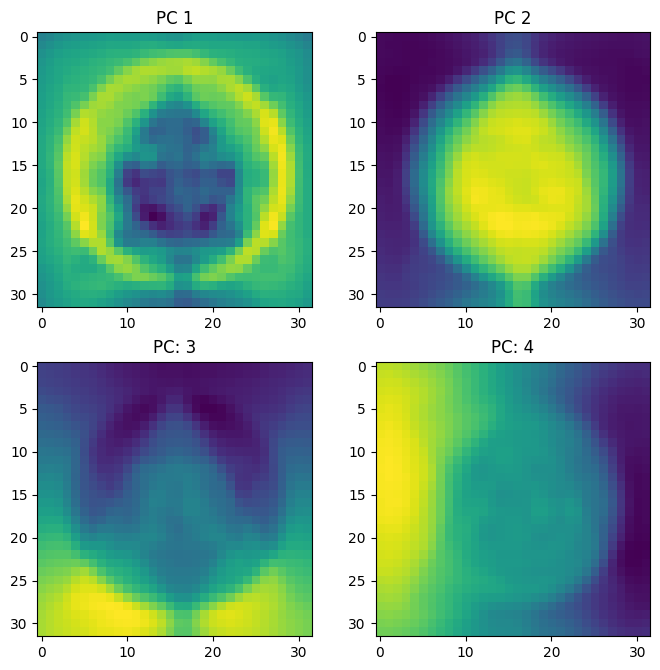

 epoch: 50, train accuracy: 0.8413131712222981, train_loss_ex:1.2753125932933624, train_loss_class: 825.7204165088489, valid_loss_ex: 1.9061270589157806, valid_loss_class: 154.21897762716281, valid_acc: 0.8344351825237137
 epoch: 100, train accuracy: 0.8614992277576237, train_loss_ex:0.9357414218974265, train_loss_class: 605.8599285359593, valid_loss_ex: 1.7903027584638667, valid_loss_class: 144.8479836440882, valid_acc: 0.8444955446967519
 epoch: 150, train accuracy: 0.8759383642828922, train_loss_ex:0.7862319501040673, train_loss_class: 509.0577609964497, valid_loss_ex: 1.7241174439199158, valid_loss_class: 139.49312993947413, valid_acc: 0.8502443230813452
 epoch: 200, train accuracy: 0.8850615997988578, train_loss_ex:0.6974258285093572, train_loss_class: 451.55889515183753, valid_loss_ex: 1.661241395103163, valid_loss_class: 134.4060189200908, valid_acc: 0.8557056625467089
 epoch: 250, train accuracy: 0.8938615710642578, train_loss_ex:0.6366285765804761, train_loss_class: 412.194795

In [3]:
## (i) With PCA on aligned

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record_ex = []
train_loss_record_class = []

train_accuracy_record = []

holdout_loss_record_ex = []
holdout_loss_record_class = []

holdout_accuracy_record = []

test_accuracy_record = []


# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss_ex = 0.0
total_test_loss_class = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data) # len(train_data) x n_components
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.PCA_generate(valid_data)
    test_d = pca.PCA_generate(test_data)

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    
    # Onehot encode labels
    y_true = onehot_encode(train_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_ex = raw_train_loss / len(train_d) # train loss per example
        train_loss_class = raw_train_loss / num_classes # train loss per class
        
        train_loss_record_ex.append(train_loss_ex)
        train_loss_record_class.append(train_loss_class)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        # TODO: early stopping, plotting std.dev., etc.
        holdout_y = softmax_model.model(valid_d)

        valid_label_onehot = onehot_encode(valid_label)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_ex = holdout_loss / len(valid_d) # holdout loss per example
        holdout_loss_class = holdout_loss / num_classes # holdout loss per class

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_loss_record_ex.append(holdout_loss_ex)
        holdout_loss_record_class.append(holdout_loss_class)
        holdout_accuracy_record.append(holdout_accuracy)

        if holdout_accuracy >= max(holdout_accuracy_record):
            best_w = softmax_model.W
            best_b = softmax_model.b

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_ex:{train_loss_ex:.4f}, train_loss_class: {train_loss_class:.4f}, '\
                f'valid_loss_ex: {holdout_loss_ex:.4f}, valid_loss_class: {holdout_loss_class:.4f}, valid_acc: {holdout_accuracy:.4f}')
    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w, best_b)

    test_label_onehot = onehot_encode(test_label)
    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    total_test_accuracy += test_accuracy

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    total_test_loss_ex += raw_test_loss / len(test_d)
    total_test_loss_class += raw_test_loss / num_classes

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {total_test_accuracy / k}')
print(f'Average test loss per ex over {k} folds: {total_test_loss_ex / k}')
print(f'Average test loss per class over {k} folds: {total_test_loss_class / k}')


In [15]:
def average_out_data_k(data, k=10):
    total_count = len(data)
    count_per_fold = total_count // k # Assumes cleanly divisble number
    new_data = [0.0 for i in range(count_per_fold)]
    for i in range(k):
        for j in range(count_per_fold):
            new_data[j] += data[i * count_per_fold + j]
    new_data = [d / k for d in new_data]
    return new_data

Text(0.5, 1.0, 'Accuracy vs. Epochs')

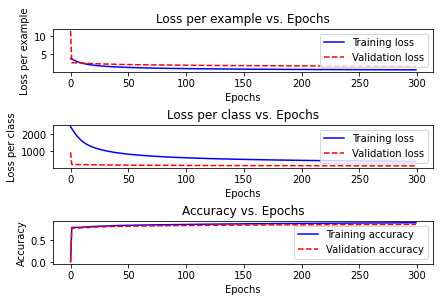

In [20]:
# TODO plots w/ error bars
fig, axs = plt.subplots(3, 1, constrained_layout=True)

axs[0].plot(average_out_data_k(train_loss_record_ex), '-b', label='Training loss')
axs[0].plot(average_out_data_k(holdout_loss_record_ex), '--r', label='Validation loss')
axs[0].legend();
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss per example')
axs[0].set_title('Loss per example vs. Epochs')

axs[1].plot(average_out_data_k(train_loss_record_class), '-b', label='Training loss')
axs[1].plot(average_out_data_k(holdout_loss_record_class), '--r', label='Validation loss')
axs[1].legend();
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss per class')
axs[1].set_title('Loss per class vs. Epochs')

axs[2].plot(average_out_data_k(train_accuracy_record), '-b', label='Training accuracy')
axs[2].plot(average_out_data_k(holdout_accuracy_record), '--r', label='Validation accuracy')
axs[2].legend();
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy vs. Epochs')


In [ ]:
## (ii) Without PCA on aligned and with PCA on unaligned
# TODO


In [ ]:
## (iii) Confusion Matrix on Test Set results
# TODO

In [ ]:
### Q6(b) - Stochastic Gradient Descent

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []


# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 1000
epochs_print = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

for train, valid, test in generate_k_fold_set((X, y), k = 10):
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    print(projected.shape)
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.PCA_generate(valid_data)
    test_d = pca.PCA_generate(test_data)

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    
    # SGD
    for epoch in range(num_epochs):
        # Shuffle indices
        indices = np.arange(len(train_d))
        indices = np.random.shuffle(indices)

        train_d = train_d[indices].squeeze(0)
        train_label = train_label[indices].squeeze(0)
        
        # Onehot encode labels
        y_true = onehot_encode(train_label)
            
        # Iterate over each example
        for i in range(len(train_d)):
            cur_ex = train_d[i][np.newaxis, ...]
            cur_label = y_true[i][np.newaxis, ...]
            y_hat = softmax_model.model(cur_ex)

            # Update Weights
            softmax_model.update_weights(cur_ex, cur_label, y_hat)

        y_hat = softmax_model.model(train_d)

        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_ex = raw_train_loss / len(train_d) # train loss per example
        train_loss_class = raw_train_loss / num_classes # train loss per class

        train_loss_record.append(raw_train_loss)

        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy}, '\
                f'train_loss_ex:{train_loss_ex}, train_loss_class: {train_loss_class}')